# SLC

## Imports

In [1]:
import os

import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Settings

In [ ]:

data_file = 'l1b'


N_PCA = 10
TRAIN_SIZE = 0.8
BATCH_SIZE = 16
EPOCH = 10
LR = 0.001   
WEIGHT_DECAY = 0.0001
PATCH_SIZE = 32
STRIDE = 16
NUM_CLASS = 3
    
VAL_EPOCH = 2
VAL_RATE = 0.1    
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 



random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

Number of bands utilized: 10
Training size: 0.8
Epochs: 10
Batch size: 16
Patch size: 128
Learning rate: 0.001
Weight decay: 0.0001


## Dataset

In [3]:
raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOLABELS'


raw_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a.nc',
    'aegean_2024-08-22T08-41-46Z-l1a.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
    'annapolis_2024-09-08T15-34-29Z-l1a.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
    'barbados_2025-03-04T13-54-23Z-l1a.nc',
    'capetown_2024-11-30T08-25-39Z-l1a.nc',
    'casablanca_2024-11-19T10-27-26Z-l1a.nc',
    'dubai_2024-11-21T06-24-16Z-l1a.nc',
    'erie_2024-09-18T15-53-53Z-l1a.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
    'florida_2024-05-21T15-51-31Z-l1a.nc',
    'florida_2024-05-30T15-34-21Z-l1a.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
    'greenbay_2024-10-01T16-22-32Z-l1a.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
    'longisland3_2024-07-15T14-49-22Z-l1a.nc',
    'longisland_2024-06-25T14-52-40Z-l1a.nc',
    'longisland_2024-08-26T14-51-29Z-l1a.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
    'marmara_2024-04-16T08-16-38Z-l1a.nc',
    'mvco_2025-03-02T14-55-47Z-l1a.nc',
    'nile_2024-11-02T07-51-59Z-l1a.nc',
    'plocan_2024-12-28T11-00-05Z-l1a.nc',
    'rogaland_2024-06-01T09-56-49Z-l1a.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
    'tasmania_2024-12-04T23-39-49Z-l1a.nc',
    'tenerife_2025-01-17T11-17-36Z-l1a.nc',
    'trondheim_2024-09-11T09-27-22Z-l1a.nc',
    'trondheim_2024-09-11T11-00-43Z-l1a.nc',
    'trondheim_2024-09-14T09-42-48Z-l1a.nc',
]

radiance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1b.nc',
    'aegean_2024-08-22T08-41-46Z-l1b.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1b.nc',
    'annapolis_2024-09-08T15-34-29Z-l1b.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1b.nc',
    'barbados_2025-03-04T13-54-23Z-l1b.nc',
    'capetown_2024-11-30T08-25-39Z-l1b.nc',
    'casablanca_2024-11-19T10-27-26Z-l1b.nc',
    'dubai_2024-11-21T06-24-16Z-l1b.nc',
    'erie_2024-09-18T15-53-53Z-l1b.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1b.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1b.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1b.nc',
    'florida_2024-05-21T15-51-31Z-l1b.nc',
    'florida_2024-05-30T15-34-21Z-l1b.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1b.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1b.nc',
    'greenbay_2024-10-01T16-22-32Z-l1b.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1b.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1b.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1b.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1b.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1b.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1b.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc',
    'longisland3_2024-07-15T14-49-22Z-l1b.nc',
    'longisland_2024-06-25T14-52-40Z-l1b.nc',
    'longisland_2024-08-26T14-51-29Z-l1b.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1b.nc',
    'marmara_2024-04-16T08-16-38Z-l1b.nc',
    'mvco_2025-03-02T14-55-47Z-l1b.nc',
    'nile_2024-11-02T07-51-59Z-l1b.nc',
    'plocan_2024-12-28T11-00-05Z-l1b.nc',
    'rogaland_2024-06-01T09-56-49Z-l1b.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1b.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1b.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1b.nc',
    'tasmania_2024-12-04T23-39-49Z-l1b.nc',
    'tenerife_2025-01-17T11-17-36Z-l1b.nc',
    'trondheim_2024-09-11T09-27-22Z-l1b.nc',
    'trondheim_2024-09-11T11-00-43Z-l1b.nc',
    'trondheim_2024-09-14T09-42-48Z-l1b.nc',
]

reflectance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1d.nc',
    'aegean_2024-08-22T08-41-46Z-l1d.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1d.nc',
    'annapolis_2024-09-08T15-34-29Z-l1d.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1d.nc',
    'barbados_2025-03-04T13-54-23Z-l1d.nc',
    'capetown_2024-11-30T08-25-39Z-l1d.nc',
    'casablanca_2024-11-19T10-27-26Z-l1d.nc',
    'dubai_2024-11-21T06-24-16Z-l1d.nc',
    'erie_2024-09-18T15-53-53Z-l1d.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1d.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1d.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1d.nc',
    'florida_2024-05-21T15-51-31Z-l1d.nc',
    'florida_2024-05-30T15-34-21Z-l1d.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1d.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1d.nc',
    'greenbay_2024-10-01T16-22-32Z-l1d.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1d.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1d.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1d.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1d.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1d.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1d.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1d.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1d.nc',
    'longisland3_2024-07-15T14-49-22Z-l1d.nc',
    'longisland_2024-06-25T14-52-40Z-l1d.nc',
    'longisland_2024-08-26T14-51-29Z-l1d.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1d.nc',
    'marmara_2024-04-16T08-16-38Z-l1d.nc',
    'mvco_2025-03-02T14-55-47Z-l1d.nc',
    'nile_2024-11-02T07-51-59Z-l1d.nc',
    'plocan_2024-12-28T11-00-05Z-l1d.nc',
    'rogaland_2024-06-01T09-56-49Z-l1d.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1d.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1d.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1d.nc',
    'tasmania_2024-12-04T23-39-49Z-l1d.nc',
    'tenerife_2025-01-17T11-17-36Z-l1d.nc',
    'trondheim_2024-09-11T09-27-22Z-l1d.nc',
    'trondheim_2024-09-11T11-00-43Z-l1d.nc',
    'trondheim_2024-09-14T09-42-48Z-l1d.nc',
]

labels_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a_labels.dat',
    'aegean_2024-08-22T08-41-46Z-l1a_labels.dat',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a_labels.dat',
    'annapolis_2024-09-08T15-34-29Z-l1a_labels.dat',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a_labels.dat',
    'barbados_2025-03-04T13-54-23Z-l1a_labels.dat',
    'capetown_2024-11-30T08-25-39Z-l1a_labels.dat',
    'casablanca_2024-11-19T10-27-26Z-l1a_labels.dat',
    'dubai_2024-11-21T06-24-16Z-l1a_labels.dat',
    'erie_2024-09-18T15-53-53Z-l1a_labels.dat',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a_labels.dat',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a_labels.dat',
    'flindersIsland_2024-11-09T23-33-38Z-l1a_labels.dat',
    'florida_2024-05-21T15-51-31Z-l1a_labels.dat',
    'florida_2024-05-30T15-34-21Z-l1a_labels.dat',
    'fredrikstad_2024-09-10T09-54-25Z-l1a_labels.dat',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a_labels.dat',
    'greenbay_2024-10-01T16-22-32Z-l1a_labels.dat',
    'grizzlybay_2024-07-18T18-20-54Z-l1a_labels.dat',
    'hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat',
    'kakhovka_2024-11-24T07-57-14Z-l1a_labels.dat',
    'kemigawa_2025-01-30T01-03-42Z-l1a_labels.dat',
    'kemigawa_2025-02-27T01-02-47Z-l1a_labels.dat',
    'kvaloya_2024-06-17T10-00-18Z-l1a_labels.dat',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a_labels.dat',
    'longisland3_2024-07-15T14-49-22Z-l1a_labels.dat',
    'longisland_2024-06-25T14-52-40Z-l1a_labels.dat',
    'longisland_2024-08-26T14-51-29Z-l1a_labels.dat',
    'malpasdam_2025-02-27T23-12-04Z-l1a_labels.dat',
    'marmara_2024-04-16T08-16-38Z-l1a_labels.dat',
    'mvco_2025-03-02T14-55-47Z-l1a_labels.dat',
    'nile_2024-11-02T07-51-59Z-l1a_labels.dat',
    'plocan_2024-12-28T11-00-05Z-l1a_labels.dat',
    'rogaland_2024-06-01T09-56-49Z-l1a_labels.dat',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a_labels.dat',
    'sicilychannel_2024-12-28T09-23-44Z-l1a_labels.dat',
    'solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat',
    'tasmania_2024-12-04T23-39-49Z-l1a_labels.dat',
    'tenerife_2025-01-17T11-17-36Z-l1a_labels.dat',
    'trondheim_2024-09-11T09-27-22Z-l1a_labels.dat',
    'trondheim_2024-09-11T11-00-43Z-l1a_labels.dat',
    'trondheim_2024-09-14T09-42-48Z-l1a_labels.dat',
]

def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  


if data_file == 'l1a':
    l1a_files, l1a_filenames = load_data(raw_data_files, raw_data_path, load_l1a_nc_cube, "L1A")
elif data_file == 'l1b':
    l1b_files, l1b_filenames = load_data(radiance_data_files, radiance_data_path, load_l1b_nc_cube, "L1B")
elif data_file == 'l1d':
    l1d_files, l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")

# Load Labels and Keep Track of Filenames
labels = []
label_filenames = []
total_labels = len(labels_files)

with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
    for idx, filename in enumerate(labels_files, start=1):
        file_path = os.path.join(labels_path, filename)
        label = np.fromfile(file_path, dtype=np.uint8)
        label = label.reshape((598, 1092))
        labels.append(label)
        label_filenames.append(filename)  # Store filename

        pbar.set_postfix_str(f"Label {idx} / {total_labels}")
        pbar.update(1)

print(f"{data_file} data shape: {l1b_files[0].shape}")
print(f"Labels shape: {labels[0].shape}")
print(f"Filename: {l1b_filenames[0]}")
print(f"Labelname: {label_filenames[0]}")

Loading labels: 100%|██████████| 43/43 [00:00<00:00, 687.98file/s, Label 43 / 43]

l1b data shape: (598, 1092, 120)
Labels shape: (598, 1092)
Filename: adriatic_2024-07-18T08-53-45Z-l1b.nc
Labelname: adriatic_2024-07-18T08-53-45Z-l1a_labels.dat


## Plot Captures and Labels

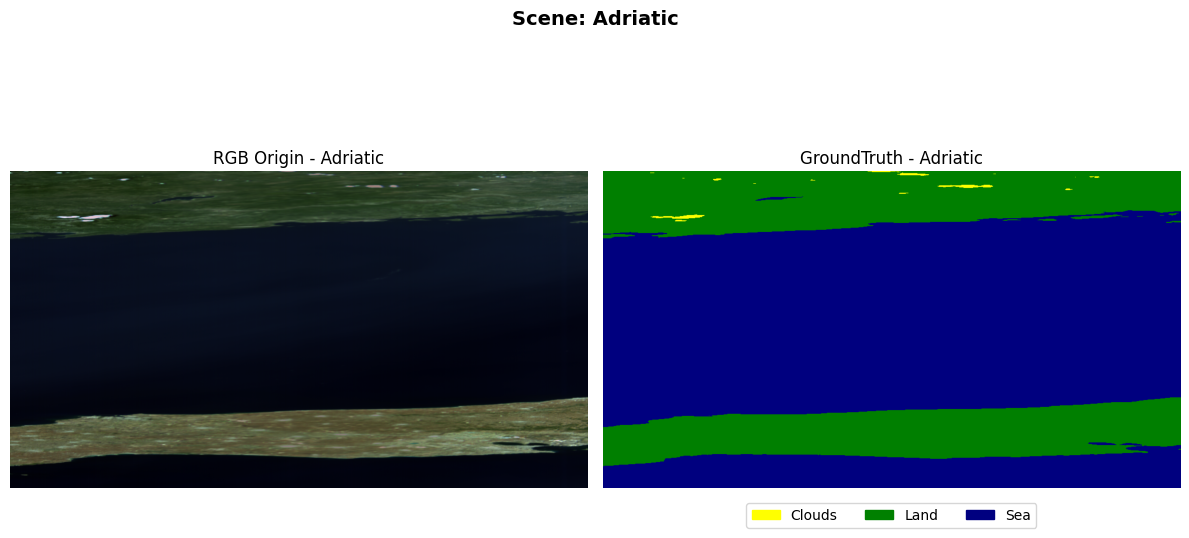

In [4]:
c1 = int(0)
#c1 = int(input("Select capture: "))
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
label = labels[c1]
scene_name = radiance_data_files[c1].split("_")[0]  



# class_names = { 1: "Snow", 2: "Land", 3: "Clouds", 4: "Sea"}  
# color_map = {
#     1: (1, 1, 1),        # Snow (white)
#     2: (0, 0.5, 0),      # Land (dark green)
#     3: (1, 1, 0),        # Clouds (yellow)
#     4: (0, 0, 0.5)       # Sea (dark blue)
# }

# Define class names and custom colormap
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots (only 2 now)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image using specified bands
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))  

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Extract unique labels present in the current label image
unique_labels = np.unique(label)

# Create legend with corresponding colors
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]

# Add legend below GroundTruth
axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## Pre-process data

### Dimensionality Reduction (PCA)

In [5]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)  
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

## Apply Transformations

In [ ]:

# Selected spectral bands to use before PCA
selected_bands = [110, 109, 111, 108, 113, 112, 107, 102, 101, 100, 99, 106, 98, 103, 97, 96,
                            81, 80, 79, 78, 77, 76, 75, 74, 82, 85, 73, 86, 84, 95, 88, 87, 72, 89, 71,
                            70, 69, 90, 83, 68, 67, 93, 64, 66, 94, 65, 63, 62, 61, 60, 59, 9, 58, 91,
                            105, 57, 10, 54, 55, 56, 92, 53, 52, 51, 11, 12, 50, 49, 48, 47, 13, 46,
                            14, 6, 4, 45, 3, 5, 7, 34, 8, 15, 16, 25, 44, 33, 43, 35, 40, 36, 17, 41,
                            42, 37, 29, 39, 32, 38, 26, 20, 19, 18, 27, 28, 30, 24, 31, 21, 23, 22, 104]

num_pca_components = N_PCA


pca_processed_images = []

if data_file == 'l1a':
    files = l1a_files
elif data_file == 'l1b':
    files = l1b_files
elif data_file == 'l1d':
    files = l1d_files





total_images = len(files)
with tqdm(total=total_images, desc="Processing PCA for images", unit="image") as pbar:
    for idx, img in enumerate(files, start=1):
        # Extract only the selected bands
        filtered_data = img[:, :, selected_bands]  # Shape: (H, W, len(selected_bands))

        # Flatten for PCA: Reshape to (pixels, bands)
        reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])

        # Apply PCA to reduce the number of bands
     
        pca = PCA(n_components=num_pca_components)
        pca_data = pca.fit_transform(reshaped_data)

        # Reshape back to (H, W, PCA components)
        pca_data = pca_data.reshape(img.shape[0], img.shape[1], num_pca_components)

        # ✅ Append EACH processed image inside the loop
        pca_processed_images.append(pca_data)

        # Update progress bar
        pbar.set_postfix_str(f"Image {idx} / {total_images}")
        pbar.update(1)

# Convert to numpy array (after all images are processed)
pca_processed_images = np.array(pca_processed_images)  # Should have shape (43, 598, 1092, num_pca_components)

processed_images = list(pca_processed_images)



if data_file == 'l1a':
    print(f"Processed {data_file} shape: {np.array(processed_images).shape}")  
elif data_file == 'l1b':
    print(f"Processed {data_file} shape: {np.array(processed_images).shape}")  
elif data_file == 'l1d':
    print(f"Processed {data_file} shape: {np.array(processed_images).shape}")  



def extract_patches(image, patch_size=32, stride=16):

    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)

    return np.array(patches)  




class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=32, stride=16, is_pred=False):
   
        self.patches = []
        self.labels = []
        self.is_pred = is_pred

        for img_idx, img in enumerate(images):
            # Extract patches for the current image
            img_patches = extract_patches(img, patch_size, stride)

            # Add extracted patches
            self.patches.extend(img_patches)

            if not is_pred and labels is not None:
                # Extract corresponding patches for labels
                label_patches = extract_patches(labels[img_idx], patch_size, stride)
                self.labels.extend(label_patches)

        # Convert to PyTorch tensors
        self.patches = torch.tensor(self.patches, dtype=torch.float32).permute(0, 3, 1, 2)  # (B, C, H, W)
        if not is_pred and labels is not None:
            self.labels = torch.tensor(self.labels, dtype=torch.long)  # Assuming categorical labels

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        if self.is_pred:
            return self.patches[idx]  # No labels in prediction mode
        return self.patches[idx], self.labels[idx]
    

def reconstruct_image(patches, original_shape, patch_size=32, stride=16):

    H, W = original_shape  # ✅ Ensure (H, W) only
    reconstructed = np.zeros((H, W), dtype=np.uint16)  # ✅ Use `uint16` to avoid overflow
    count = np.zeros((H, W), dtype=np.uint16)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            reconstructed[i:i+patch_size, j:j+patch_size] += patches[patch_idx].astype(np.uint16)  # ✅ Convert dtype
            count[i:i+patch_size, j:j+patch_size] += 1
            patch_idx += 1


    return (reconstructed / np.maximum(count, 1)).astype(np.uint8)



Processing PCA for images: 100%|██████████| 43/43 [00:39<00:00,  1.10image/s, Image 43 / 43]


Processed l1b shape: (43, 598, 1092, 10)


## Data Split

In [7]:
(training_files, testing_files, 
 training_labels, testing_labels, 
 training_filenames, testing_filenames, 
 training_label_filenames, testing_label_filenames) = train_test_split(
    processed_images, labels, l1b_filenames, label_filenames, 
    test_size=1 - TRAIN_SIZE, random_state=42
)

VALIDATION_SIZE = 0.2

(train_images, val_images, 
 train_labels, val_labels, 
 train_filenames, val_filenames, 
 train_label_filenames, val_label_filenames) = train_test_split(
    training_files, training_labels, training_filenames, training_label_filenames,
    test_size=VALIDATION_SIZE, random_state=42
)


print(f"✅ Training Set: {len(train_images)} images")
print(f"✅ Testing Set: {len(testing_files)} images")
print(f"✅ Validation Set: {len(val_images)} images")

# Print first 5 training examples
print("\n--- Training Set ---")
for i in range(5):
    print(f"Data File: {train_filenames[i]}  |  Label File: {train_label_filenames[i]}")

# Print first 5 testing examples
print("\n--- Testing Set ---")
for i in range(4):
    print(f"Data File: {testing_filenames[i]}  |  Label File: {testing_label_filenames[i]}")

# Print first 5 validation examples
print("\n--- Validation Set ---")
for i in range(3):
    print(f"Data File: {val_filenames[i]}  |  Label File: {val_label_filenames[i]}")


✅ Training Set: 27 images
✅ Testing Set: 9 images
✅ Validation Set: 7 images

--- Training Set ---
Data File: longisland3_2024-07-15T14-49-22Z-l1b.nc  |  Label File: longisland3_2024-07-15T14-49-22Z-l1a_labels.dat
Data File: longisland_2024-08-26T14-51-29Z-l1b.nc  |  Label File: longisland_2024-08-26T14-51-29Z-l1a_labels.dat
Data File: erie_2024-09-18T15-53-53Z-l1b.nc  |  Label File: erie_2024-09-18T15-53-53Z-l1a_labels.dat
Data File: annapolis_2024-09-08T15-34-29Z-l1b.nc  |  Label File: annapolis_2024-09-08T15-34-29Z-l1a_labels.dat
Data File: hawkebay_2024-12-23T21-43-24Z-l1b.nc  |  Label File: hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat

--- Testing Set ---
Data File: solbergstrand_2024-07-08T09-39-39Z-l1b.nc  |  Label File: solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat
Data File: lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc  |  Label File: lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat
Data File: lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc  |  Label File: lakewinnipeg_2024-0

## Patching

In [ ]:


train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE) 
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)  


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_1708\2829591688.py:108: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.patches = torch.tensor(self.patches, dtype=torch.float32).permute(0, 3, 1, 2)  # (B, C, H, W)


## Create dataset and dataloader

In [9]:
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=32, stride=16):
        self.patches = []
        self.image_indices = []

        for img_idx, img in enumerate(images):
            img_patches = extract_patches(img, patch_size, stride)
            self.patches.extend(img_patches)
            self.image_indices.extend([img_idx] * len(img_patches))

        self.patches = torch.tensor(self.patches, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.image_indices[idx]


In [ ]:
test_data = TestPatchSet(testing_files, PATCH_SIZE, STRIDE)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total test patches: {len(test_data)}")


Total test patches: 21708


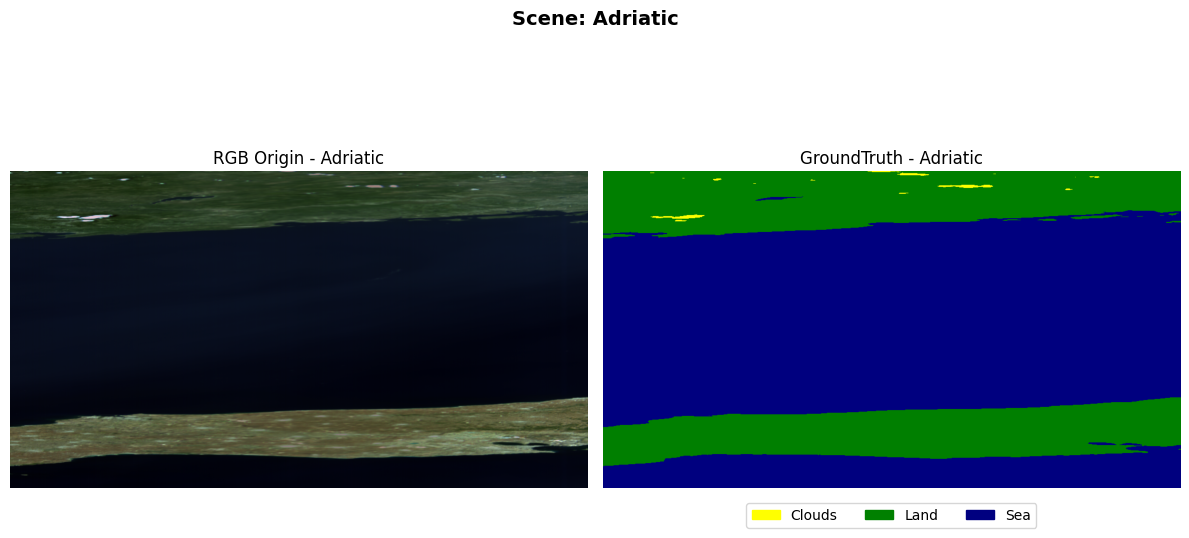

In [12]:
c1 = int(0)
#c1 = int(input("Select capture: "))
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
label = labels[c1]
scene_name = radiance_data_files[c1].split("_")[0]  



# class_names = { 1: "Snow", 2: "Land", 3: "Clouds", 4: "Sea"}  
# color_map = {
#     1: (1, 1, 1),        # Snow (white)
#     2: (0, 0.5, 0),      # Land (dark green)
#     3: (1, 1, 0),        # Clouds (yellow)
#     4: (0, 0, 0.5)       # Sea (dark blue)
# }

# Define class names and custom colormap
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots (only 2 now)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image using specified bands
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))  

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Extract unique labels present in the current label image
unique_labels = np.unique(label)

# Create legend with corresponding colors
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]

# Add legend below GroundTruth
axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## Model

In [13]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
        # Projection and convolution blocks with the same channel progression as the classification model
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        for i in range(levels):
            # Keep the same channel calculation logic from the classification model
            input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
            output_channels = 64 * (i + 1)
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))
        
        # Replace global pooling and FC layer with segmentation head
        total_channels = sum(64 * (i + 1) for i in range(levels))
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(total_channels // 2, class_nums, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.shape[2:]  # Store original input size
        features = []
        low_pass = x
        
        # Wavelet processing (same as before)
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)
            
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]
            
            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)
        
        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)
        
        # Upscale back to input size for segmentation
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
        return out


In [14]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)



Input tensor shape: torch.Size([1, 10, 32, 32])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 10, 32, 32]    [1, 3, 32, 32]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 10, 32, 32]    [1, 10, 16, 16]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        2,624              [1, 1]             671,744            [1, 40, 16, 16]    [1, 64, 16, 16]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 64, 16, 16

## Training

Using device: cuda


Training::  10%|█         | 1/10 [00:29<04:23, 29.25s/it]

epoch 0/10 loss:2.2696547841985583e-05  acc:0.85499846326815


100%|██████████| 4071/4071 [00:29<00:00, 139.86it/s]


epoch 1/10 loss:1.6052031892402796e-05  acc:0.9010590463721132


Training::  20%|██        | 2/10 [01:04<04:20, 32.62s/it]

epoch 1/10  val_acc:0.774236090288883
Epoch 2/10 completed in 34.97 seconds.


Training::  30%|███       | 3/10 [01:33<03:36, 30.95s/it]

epoch 2/10 loss:1.4068482087805766e-05  acc:0.9134746640783352


100%|██████████| 4071/4071 [00:28<00:00, 140.43it/s]


epoch 3/10 loss:1.2769511311673522e-05  acc:0.9207845471955424


Training::  40%|████      | 4/10 [02:08<03:14, 32.50s/it]

epoch 3/10  val_acc:0.8265055512060234
Epoch 4/10 completed in 34.86 seconds.


Training::  50%|█████     | 5/10 [02:37<02:36, 31.23s/it]

epoch 4/10 loss:1.2130131105725965e-05  acc:0.9241172069340796


100%|██████████| 4071/4071 [00:29<00:00, 140.17it/s]


epoch 5/10 loss:1.1776822142458562e-05  acc:0.9261614291822139


Training::  60%|██████    | 6/10 [03:11<02:09, 32.44s/it]

epoch 5/10  val_acc:0.8250633227093698
Epoch 6/10 completed in 34.78 seconds.


Training::  70%|███████   | 7/10 [03:40<01:33, 31.07s/it]

epoch 6/10 loss:1.1469553705705064e-05  acc:0.9278319802655319


100%|██████████| 4071/4071 [00:27<00:00, 145.88it/s]


epoch 7/10 loss:1.1216358729972167e-05  acc:0.9293840674376957


Training::  80%|████████  | 8/10 [04:13<01:03, 31.86s/it]

epoch 7/10  val_acc:0.8271196912572554
Epoch 8/10 completed in 33.55 seconds.


Training::  90%|█████████ | 9/10 [04:41<00:30, 30.73s/it]

epoch 8/10 loss:1.1092942349661923e-05  acc:0.9297682504001981


100%|██████████| 4071/4071 [00:28<00:00, 143.60it/s]


epoch 9/10 loss:1.1006007633635634e-05  acc:0.9302668485072707


Training:: 100%|██████████| 10/10 [05:15<00:00, 31.58s/it]


epoch 9/10  val_acc:0.8262267068674485
Epoch 10/10 completed in 33.96 seconds.
Training completed in 315.84 seconds.
Stop in epoch 9


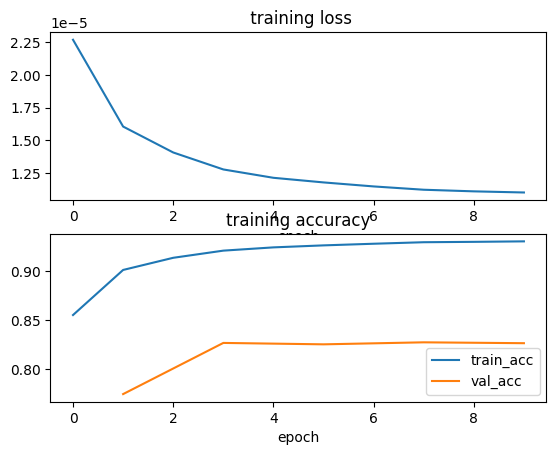

In [15]:
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
model.to(device)
#optimizer = torch.optim.SGD(model.parameters(), LR,weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE
val_num = val_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

e = -1


start_time = time.time()

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)


            epoch_end_time = time.time()
            print(f"Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")



    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title(' training loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('training accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    print(f'Stop in epoch {e}')

### Save Best Model

In [16]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_1708\40373799.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_p

best model:epoch_7_acc_0.8271.pth
✅ Loading Best Model from: results\l1b\epoch_7_acc_0.8271.pth
✅ Model loaded successfully. Ready for inference!

Processing Test Image 1/9 - Scene: solbergstrand_2024-07-08T09-39-39Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 1: 100%|██████████| 19/19 [00:01<00:00, 15.96it/s]


Unique classes in prediction before plotting: [0 1 2]


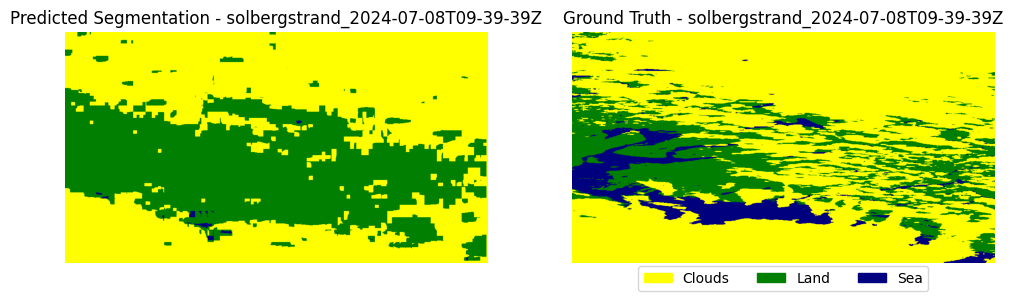


Processing Test Image 2/9 - Scene: lagunaDeTerminos_2024-12-06T16-07-50Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2: 100%|██████████| 19/19 [00:01<00:00, 18.16it/s]


Unique classes in prediction before plotting: [0 1 2]


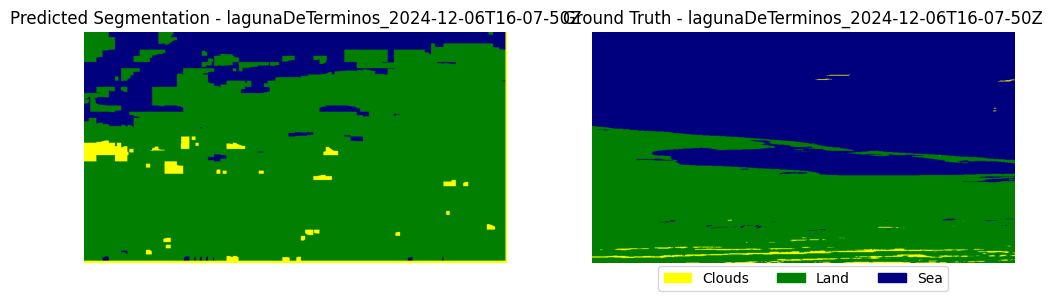


Processing Test Image 3/9 - Scene: lakewinnipeg_2024-08-13T17-07-06Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 3: 100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Unique classes in prediction before plotting: [0 1 2]


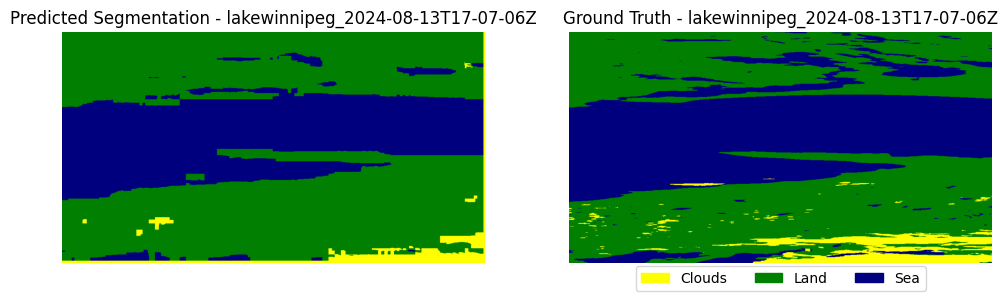


Processing Test Image 4/9 - Scene: sicilychannel_2024-12-28T09-23-44Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 4: 100%|██████████| 19/19 [00:01<00:00, 16.64it/s]


Unique classes in prediction before plotting: [0 1 2]


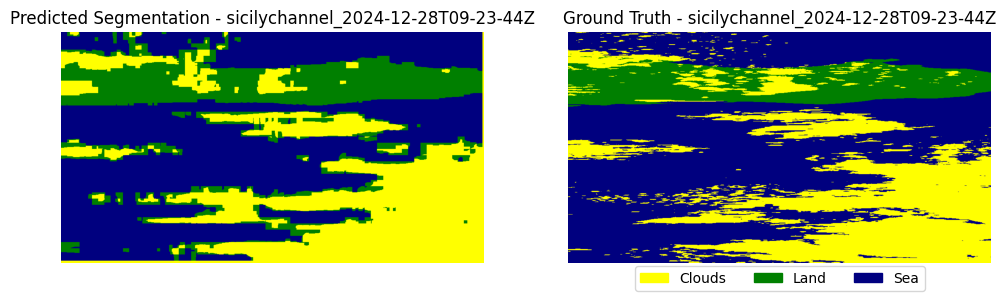


Processing Test Image 5/9 - Scene: rogaland_2024-06-01T09-56-49Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 5: 100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Unique classes in prediction before plotting: [0 1 2]


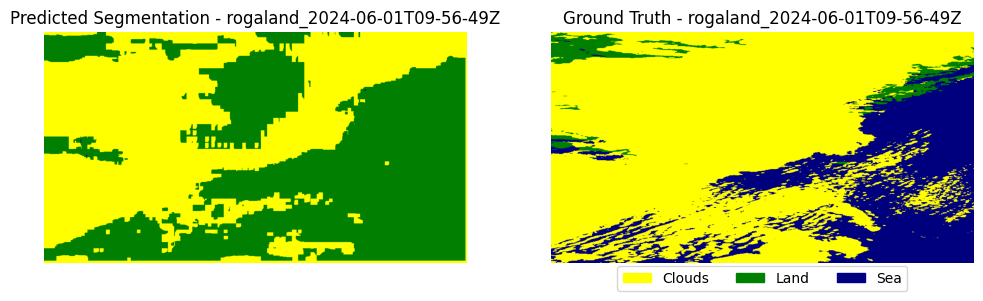


Processing Test Image 6/9 - Scene: tenerife_2025-01-17T11-17-36Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 6: 100%|██████████| 19/19 [00:01<00:00, 16.92it/s]


Unique classes in prediction before plotting: [0 1 2]


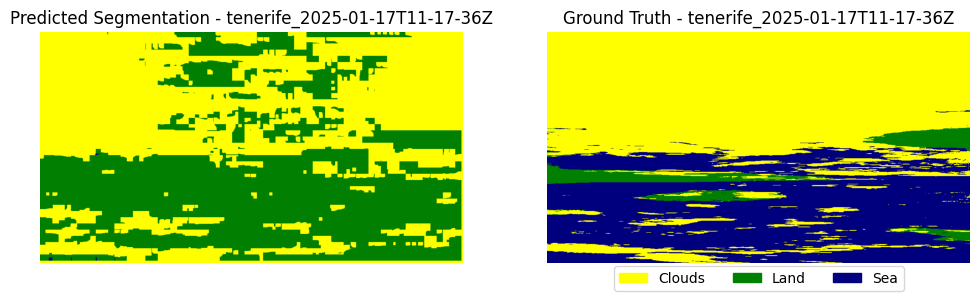


Processing Test Image 7/9 - Scene: aquawatchplymouth_2025-03-04T10-37-14Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 7: 100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


Unique classes in prediction before plotting: [0 1 2]


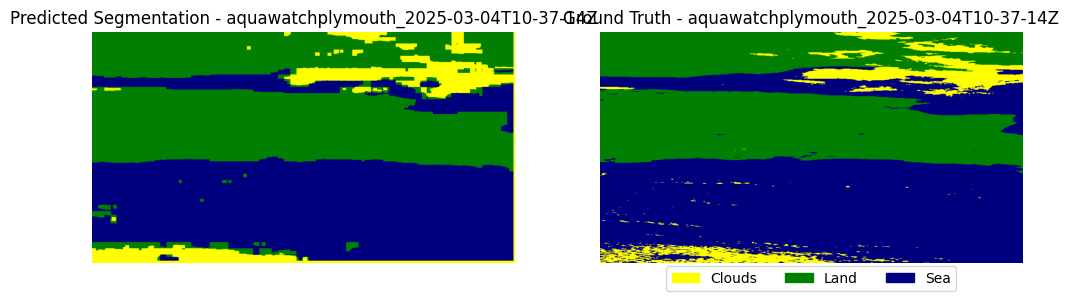


Processing Test Image 8/9 - Scene: flindersIsland_2024-11-09T23-33-38Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 8: 100%|██████████| 19/19 [00:01<00:00, 16.87it/s]


Unique classes in prediction before plotting: [0 1 2]


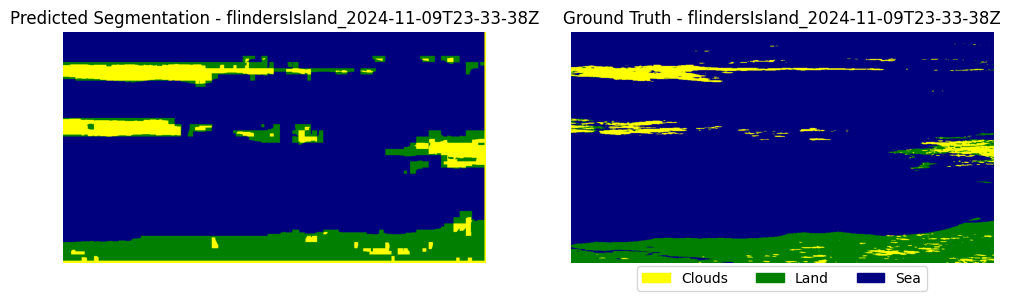


Processing Test Image 9/9 - Scene: dubai_2024-11-21T06-24-16Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 9: 100%|██████████| 19/19 [00:01<00:00, 17.45it/s]


Unique classes in prediction before plotting: [0 1 2]


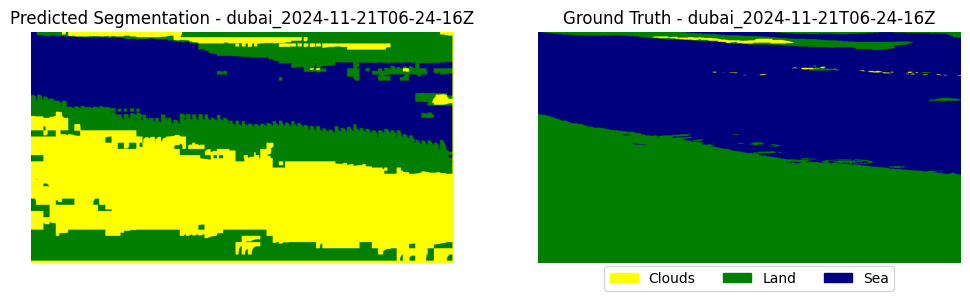

In [17]:

import os
import spectral
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Define class names and color map (same as original ground truth)
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert dictionary to a ListedColormap for Matplotlib
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# ✅ Pre-load the correct ground truth labels for the test files
testing_label_dict = {
    os.path.basename(fname).replace("-l1a_labels.dat", ""): label
    for fname, label in zip(label_filenames, labels)
}

## Load the best trained model
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"✅ Loading Best Model from: {best_model_path}")

best_model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully. Ready for inference!")


# ✅ Process each test image separately
for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label


    # ✅ Ensure Ground Truth is Unmodified
    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    # ✅ Get the test image data
    test_img = testing_files[img_idx]

    # Create dataset and DataLoader for the current test image
    test_data = TestPatchSet([test_img], patch_size=32, stride=16)
    test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

    ## Initialize storage for predicted patches
    pred_patches = []

    # Process all patches for this test image
    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)  

        # Get model predictions
        out = best_model(data)
        _, pred = torch.max(out, dim=1)  # Get class predictions

        # Convert to numpy and store
        pred_patches.append(pred.detach().cpu().numpy())

    ## Convert predictions into a single array
    pred_patches = np.concatenate(pred_patches, axis=0)

    ## Reconstruct the predicted segmentation map
    original_shape = test_img.shape[:2]  # Extract (H, W) only
    pred_map = reconstruct_image(pred_patches, original_shape, patch_size=32, stride=16)

    ## ✅ Ensure Predictions Contain All Expected Classes
    print(f"Unique classes in prediction before plotting: {np.unique(pred_map)}")

    ## ✅ Create Side-by-Side Comparison Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Show prediction
    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Predicted Segmentation - {scene_name}')
    axes[0].axis("off")  

    # Show ground truth
    axes[1].imshow(ground_truth, cmap=custom_cmap)  # ✅ No reshaping, directly plots as loaded
    axes[1].set_title(f'Ground Truth - {scene_name}')
    axes[1].axis("off")  

    # ✅ Create legend
    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

    # ✅ Show the plot
    plt.show()


## Evaluation

In [23]:
all_true_labels = []
all_pred_labels = []
eval_results = []

for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label

    ## ✅ Extract valid pixels (ignore background pixels where ground truth is 0)
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    ## ✅ Compute metrics for this individual image
    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)

    unique_classes = np.unique(test_true)

    # ✅ Ensure only present classes are used in target_names
    target_names = [class_names[c] for c in unique_classes if c in class_names]

    # ✅ Compute classification report with dynamically detected classes
    class_report = classification_report(test_true, test_pred, labels=unique_classes, target_names=target_names, digits=4, zero_division=0)


    # ✅ Store the individual results
    eval_results.append({
        "Scene": scene_name,
        "Overall Accuracy": round(OA, 4),
        "Average Accuracy": round(AA, 4),
        "Kappa Score": round(kappa, 4),
        "Classification Report": class_report
    })

    ## ✅ Append results for total evaluation
    all_true_labels.extend(test_true)
    all_pred_labels.extend(test_pred)

    ## ✅ Print individual report
    print(f"\n📌 Evaluation for {scene_name}:")
    print(f"OA: {OA:.4f} | AA: {AA:.4f} | Kappa: {kappa:.4f}")
    print(class_report)
    print("-" * 80)



## ✅ Convert lists to NumPy arrays
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

## ✅ Compute overall metrics
OA_total = accuracy_score(all_true_labels, all_pred_labels)
AA_total = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
kappa_total = cohen_kappa_score(all_true_labels, all_pred_labels)
# ✅ Dynamically get unique class values
unique_classes_overall = np.unique(all_true_labels)

# ✅ Ensure only present classes are used in target_names
target_names_overall = [class_names[c] for c in unique_classes_overall if c in class_names]

# ✅ Compute classification report with dynamically detected classes
overall_class_report = classification_report(all_true_labels, all_pred_labels, labels=unique_classes_overall, target_names=target_names_overall, digits=4, zero_division=0)

## ✅ Store final evaluation
eval_results.append({
    "Scene": "Overall",
    "Overall Accuracy": round(OA_total, 4),
    "Average Accuracy": round(AA_total, 4),
    "Kappa Score": round(kappa_total, 4),
    "Classification Report": overall_class_report
})

## ✅ Print overall report
print("\n📊 Overall Evaluation Across All Predicted Images:")
print(f"Overall Accuracy: {OA_total:.4f} | Average Accuracy: {AA_total:.4f} | Kappa: {kappa_total:.4f}")
print(overall_class_report)







Processing Test Image 1/9 - Scene: solbergstrand_2024-07-08T09-39-39Z

📌 Evaluation for solbergstrand_2024-07-08T09-39-39Z:
OA: 0.3520 | AA: 0.1319 | Kappa: -0.2332
              precision    recall  f1-score   support

      Clouds     0.5659    0.4903    0.5254    457930
        Land     0.0370    0.0374    0.0372    143056
         Sea     0.0000    0.0000    0.0000     52030

   micro avg     0.4248    0.3520    0.3850    653016
   macro avg     0.2010    0.1759    0.1875    653016
weighted avg     0.4049    0.3520    0.3766    653016

--------------------------------------------------------------------------------

Processing Test Image 2/9 - Scene: lagunaDeTerminos_2024-12-06T16-07-50Z

📌 Evaluation for lagunaDeTerminos_2024-12-06T16-07-50Z:
OA: 0.0956 | AA: 0.0586 | Kappa: -0.0092
              precision    recall  f1-score   support

      Clouds     0.0003    0.0136    0.0006      8872
        Land     0.4316    0.2207    0.2921    282426
         Sea     0.0000    0.0000    